# The datasets

The dataset used for this project comes from [Insideairbnb.com](https://insideairbnb.com/), an anti-Airbnb lobby group that scrapes Airbnb listings, reviews and calendar data for multiple cities around the world.

Inside Airbnb Data Dictionary: 
https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=982310896

# Setup Libraries and function

In [1]:
# Common imports
# Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
#import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import os 
from sklearn.metrics import mean_absolute_error
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    try:
        plt.savefig(path, format=fig_extension, dpi=resolution)
    except:
        plt.savefig(fig_id + "." + fig_extension, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
pd.options.display.max_columns = None


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data wrangling and cleaning

In [2]:
listings_March = pd.read_csv("/content/drive/MyDrive/airbnb/listings.csv")
listings_June = pd.read_csv("/content/drive/MyDrive/airbnb/listings_1.csv")
listings_September = pd.read_csv("/content/drive/MyDrive/airbnb/listings_2.csv")
listings_December = pd.read_csv("/content/drive/MyDrive/airbnb/listings_3.csv")

In [3]:
listings_list = [listings_March, listings_June, listings_September, listings_December]
listings = pd.concat(listings_list)

In [4]:
# Importing regex
import re

bath = ["bathrooms_text"]
for col in bath:
    listings[col] = listings[col].apply(lambda x: str(re.compile('[a-zA-Z]').sub('', str(x))))
    listings[col] = listings[col].apply(lambda x: str(re.compile(' ').sub('', str(x))))

In [5]:
listings["bathrooms"] = pd.to_numeric(listings["bathrooms_text"],errors='coerce')
listings.drop(['bathrooms_text'], axis=1, inplace=True)

In [6]:
# The price fields in our data frame
price_list = ["price"]

# We change any blanks to 0 and use our regex function to remove anything that isn't a number (or negative number which is changed to 0)
for col in price_list:
    listings[col] = listings[col].fillna("0")
    listings[col] = listings[col].apply(lambda x: float(re.compile('[^0-9eE.]').sub('', x)) if len(x)>0 else 0)

## Drop init columns

The free text columns will be dropped for now, as will other columns which are not useful for predicting price (e.g. url, host name and other host-related features that are unrelated to the property).

In [7]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
listings = listings.drop(cols_to_drop, axis=1)

In [8]:
listings.isna().sum()

id                                                  0
host_since                                        138
host_response_time                              39540
host_response_rate                              39540
host_acceptance_rate                            36034
host_is_superhost                                 138
host_listings_count                               138
host_total_listings_count                         138
host_has_profile_pic                              138
host_identity_verified                            138
neighbourhood                                   19471
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                    56846
latitude                                            0
longitude                                           0
property_type                                       0
room_type                                           0
accommodates                                        0
bathrooms                   

Other columns can be dropped because they contain a majority of null entries.

In [9]:
listings.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'license'], axis=1, inplace=True)

listings.set_index('id', inplace=True) # The id will be used as the index, as this could be useful in future e.g. if a separate dataset containing reviews for each property is linked to this one

`host_listings_count` and `host_total_listings_count` are the same in all but 138 cases. These cases are those where the value is NaN. Therefore one of these columns can be dropped.

In [10]:
print(sum((listings.host_listings_count == listings.host_total_listings_count) == False))

138


In [11]:
listings.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
               'calculated_host_listings_count_private_rooms', 
               'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

There are multiple columns for minimum and maximum night stays, but the two main ones will be used as there are few differences between e.g. minimum_nights and minimum_minimum_nights.

In [12]:
listings.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

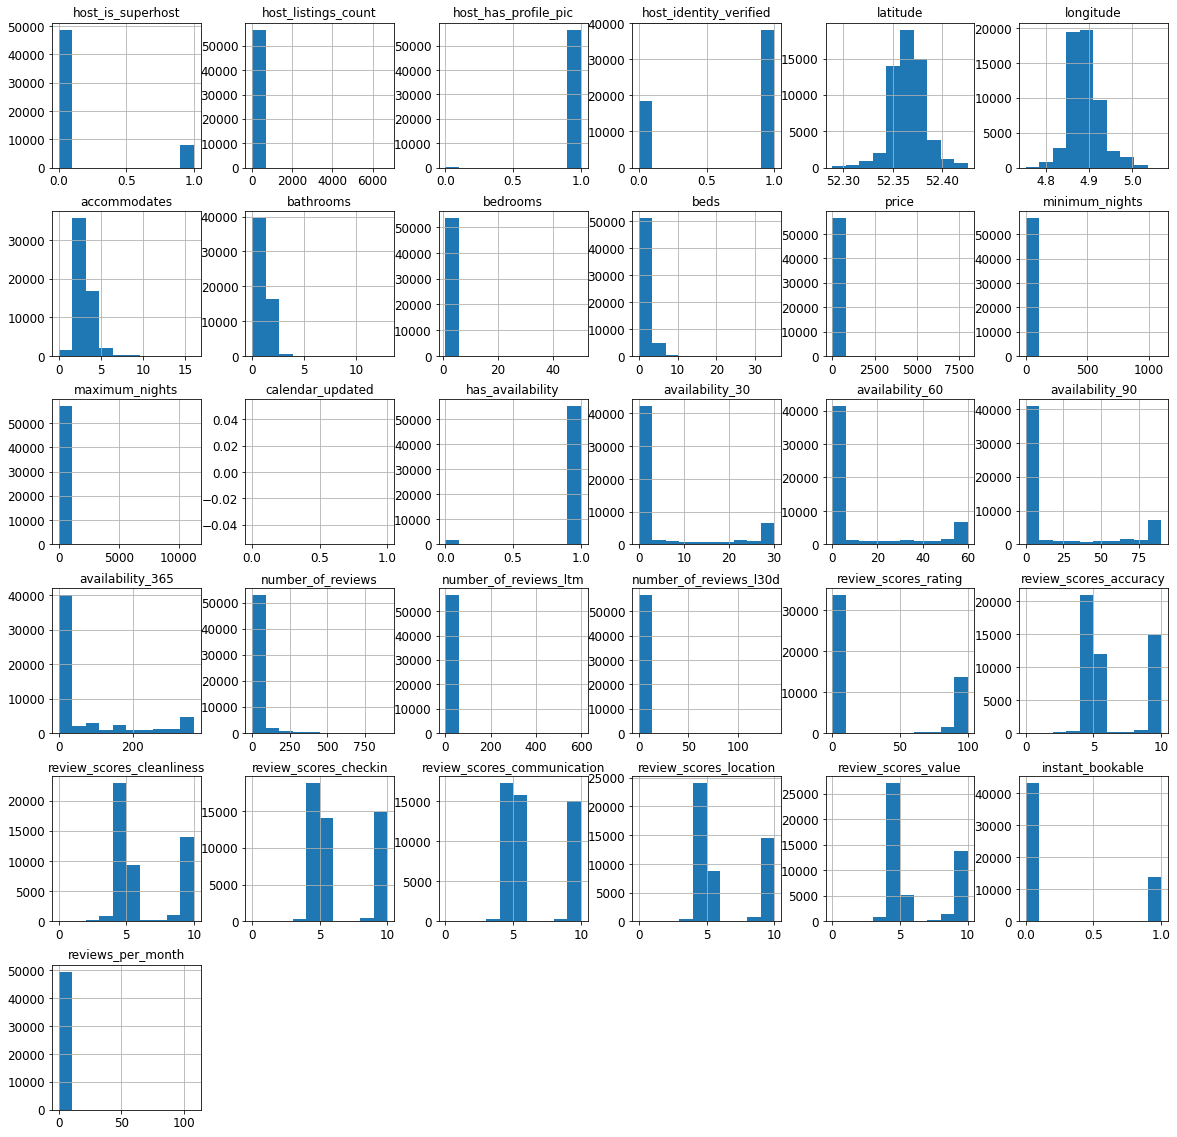

In [13]:
# Replacing columns with f/t with 0/1
listings.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
listings.hist(figsize=(20,20));

From the above, it can be seen that several columns only contain one category and can be dropped:

In [14]:
listings.drop(['has_availability','host_has_profile_pic'], axis=1, inplace=True)

These will be highly correlated with number_of_reviews and so will be dropped.

In [15]:
listings.drop(['number_of_reviews_ltm','number_of_reviews_l30d', 'reviews_per_month'], axis=1, inplace=True)

There are multiple different measures of availability, which will be highly correlated with each other. Only one will be retained - for 30 days.

*You can only rent out your entire home in Amsterdam for a maximum of 30 nights per year, unless you have a specific permit that allows you to rent out your home for more nights, such as a short term stay license.* - AirBnB

https://www.airbnb.com/help/article/860/amsterdam

In [16]:
listings.drop(['availability_90', 'availability_60', 'availability_365'], axis=1, inplace=True)

In [17]:
listings.drop(['calendar_updated'], axis=1, inplace=True)

## Cleaning columns

### **Host since**

*The date that the host first joined Airbnb*

In [18]:
# Converting to datetime
listings.host_since = pd.to_datetime(listings.host_since) 

# Calculating the number of days
listings['host_days_active'] = (datetime(2021, 12, 31) - listings.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(listings['host_days_active'].mean(),0))
print("Median days as host:", listings['host_days_active'].median())

# Replacing null values with the median
listings.host_days_active.fillna(listings.host_days_active.median(), inplace=True)

Mean days as host: 2397.0
Median days as host: 2474.0


### **Host is superhost**

In [19]:
# Number of rows without a value for multiple host-related columns
len(listings[listings.loc[ :,['host_is_superhost', 'host_listings_count', 'host_identity_verified'] ].isnull().sum(axis=1) == 3])

138

In [20]:
listings.dropna(subset=['host_since'], inplace=True)

### **Host response time**
*The average amount of time the host takes to reply to messages*

In [21]:
print("Null values:", listings.host_response_time.isna().sum())
print(f"Proportion: {round((listings.host_response_time.isna().sum()/len(listings))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not yet had a review
len(listings[listings.loc[ :,['host_response_time', 'first_review'] ].isnull().sum(axis=1) == 2])

Null values: 39402
Proportion: 69.5%


5287

In [22]:
listings.host_response_time.fillna("unknown", inplace=True)
listings.host_response_time.value_counts(normalize=True)

unknown               0.694823
within an hour        0.153576
within a day          0.064259
within a few hours    0.062936
a few days or more    0.024406
Name: host_response_time, dtype: float64

### **Host response rate**
*The proportion of messages that the host replies to*

In [23]:
print("Null values:", listings.host_response_rate.isna().sum())
print(f"Proportion: {round((listings.host_response_rate.isna().sum()/len(listings))*100, 1)}%")

Null values: 39402
Proportion: 69.5%


In [24]:
# Removing the % sign from the host_response_rate string and converting to an integer
listings.host_response_rate = listings.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(listings['host_response_rate'].mean(),0))
print("Median host response rate:", listings['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((listings.host_response_rate == 100.0).sum()/listings.host_response_rate.count())*100,1)}%")

Mean host response rate: 89.0
Median host response rate: 100.0
Proportion of 100% host response rates: 70.4%


In [25]:
# Bin into four categories
listings.host_response_rate = pd.cut(listings.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
listings.host_response_rate = listings.host_response_rate.astype('str')

# Replace nulls with 'unknown'
listings.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
listings.host_response_rate.value_counts()

unknown    39402
100%       12192
50-89%      2320
0-49%       1754
90-99%      1040
Name: host_response_rate, dtype: int64

### **Property type**
*The type of property, e.g. house or flat*

In [26]:
pd.options.display.max_rows = 10000
listings.property_type.value_counts()

Entire apartment                       21700
Entire rental unit                     12112
Private room in apartment               4248
Private room in rental unit             2438
Entire house                            2278
Entire townhouse                        1500
Entire residential home                 1395
Private room in bed and breakfast       1257
Entire loft                              934
Houseboat                                666
Private room in house                    653
Boat                                     649
Room in boutique hotel                   629
Entire condominium (condo)               627
Private room in townhouse                570
Entire serviced apartment                528
Entire condominium                       509
Private room in houseboat                436
Private room in residential home         427
Private room in guest suite              410
Room in hotel                            404
Private room in boat                     344
Private ro

In [27]:
# Replacing categories that are types of houses or apartments
listings.property_type.replace({
    'Entire apartment': 'Apartment',
    'Entire rental unit':'Apartment',
    'Entire serviced apartment': 'Apartment',
    'Entire loft': 'Apartment',
    'Entire guesthouse':'House',
    'Entire house': 'House',
    'Entire townhouse':'House',
    'Entire residential home': 'House',
    'Houseboat':'House',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Entire villa': 'House',
    'Entire guesthouse':'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
listings.loc[~listings.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

### **Bathrooms, bedrooms and beds**

Missing values will be replaced with the median (to avoid strange fractions).

In [28]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    listings[col].fillna(listings[col].median(), inplace=True)

### **Amenities**

Amenities is a list of additional features in the property, e.g. whether it has a TV or parking. Examples are below:

In [29]:
# Creating a set of all possible amenities
amenities_list = list(listings.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('[', '')
amenities_list_string = amenities_list_string.replace(']', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_list_string = amenities_list_string.replace('', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 'Keurig coffee machine',
 'Unicura anti-bacterial handsoap body soap',
 'Wifi \\u2013 22 Mbps',
 'The Spa Collection conditioner',
 'Pour-over coffee',
 'R/ CDplayer sound system',
 'MARIE-STELLA-MARIS shampoo',
 'Harman Kardon sound system with aux',
 'Fast wifi \\u2013 489 Mbps',
 'good sound - connect with Spotifypremium Bluetooth sound system',
 'L\\u2019Or\\u00e9al Elvive conditioner',
 'bora induction stove',
 'siemens gas stove',
 'minifridge available on request refrigerator',
 'Gym',
 'AEG induction stove',
 'Siemens electric stove',
 'eco soap body soap',
 '35\\ HDTV with Apple TV',
 'Mostly supermarket shampoo shampoo',
 'Free parking garage on premises \\u2013 1 space',
 'eco friendly body soap',
 'Ikea stainless steel oven',
 'Unicura body soap',
 'Clothing storage: dresser and closet',
 '2-5 years old',
 'Ethernet connection',
 'Extra pillows and blankets',
 'and wardrobe',
 'Bio conditioner',
 'Children\\u2019s books and toys for ages 5-10 years old and 10+ years o

In [30]:
listings.loc[listings['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
listings.loc[listings['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
listings.loc[listings['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
listings.loc[listings['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
listings.loc[listings['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
listings.loc[listings['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
listings.loc[listings['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
listings.loc[listings['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
listings.loc[listings['amenities'].str.contains('TV'), 'tv'] = 1
listings.loc[listings['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
listings.loc[listings['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
listings.loc[listings['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
listings.loc[listings['amenities'].str.contains('Elevator'), 'elevator'] = 1
listings.loc[listings['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
listings.loc[listings['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
listings.loc[listings['amenities'].str.contains('parking'), 'parking'] = 1
listings.loc[listings['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
listings.loc[listings['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
listings.loc[listings['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
listings.loc[listings['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
listings.loc[listings['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
listings.loc[listings['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
listings.loc[listings['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
listings.loc[listings['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
listings.loc[listings['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
listings.loc[listings['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
listings.loc[listings['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
listings.loc[listings['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [31]:
listings.iloc[:,33:].columns

Index(['check_in_24h', 'air_conditioning', 'high_end_electronics', 'bbq',
       'balcony', 'nature_and_views', 'bed_linen', 'breakfast', 'tv',
       'coffee_machine', 'cooking_basics', 'white_goods', 'elevator', 'gym',
       'child_friendly', 'parking', 'outdoor_space', 'host_greeting',
       'hot_tub_sauna_or_pool', 'internet', 'long_term_stays', 'pets_allowed',
       'private_entrance', 'secure', 'self_check_in', 'smoking_allowed',
       'accessible', 'event_suitable'],
      dtype='object')

In [32]:
# # Replacing nulls with zeros for new columns
cols_to_replace_nulls = listings.iloc[:,33:].columns
listings[cols_to_replace_nulls] = listings[cols_to_replace_nulls].fillna(0)

# # Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in listings.iloc[:,33:].columns:
    if listings[col].sum() < len(listings)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# # Dropping infrequent amenity features
listings.drop(infrequent_amenities, axis=1, inplace=True)

# # Dropping the original amenity feature
listings.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'air_conditioning', 'high_end_electronics', 'bbq', 'nature_and_views', 'breakfast', 'elevator', 'gym', 'outdoor_space', 'hot_tub_sauna_or_pool', 'pets_allowed', 'secure', 'self_check_in', 'smoking_allowed', 'accessible', 'event_suitable']


### **First review and last review**

*the date of the first review and the date of the most recent review*

In [33]:
print(f"Null values in 'first_review': {round(100*listings.first_review.isna().sum()/len(listings),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*listings.review_scores_rating .isna().sum()/len(listings),1)}%")

Null values in 'first_review': 12.8%
Null values in 'review_scores_rating': 13.3%


About a quarter of listings have not had a review written for them

This is too large a proportion of the dataset to drop, and dropping the columns would lose a lot of useful information - reviews are very important in people's decisions to book, and therefore price.

In [34]:
listings.first_review = pd.to_datetime(listings.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
listings['time_since_first_review'] = (datetime(2021, 12, 31) - listings.first_review).astype('timedelta64[D]')

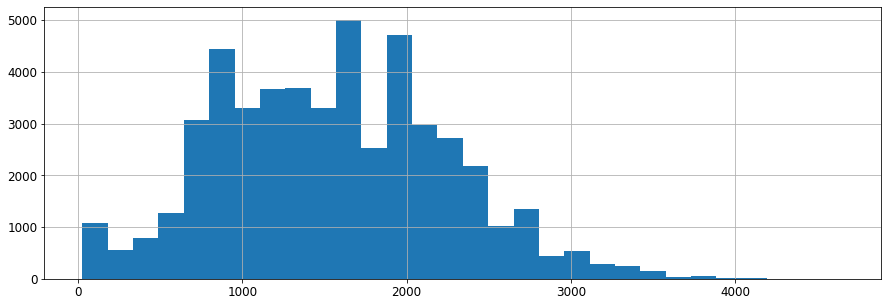

In [35]:
listings.time_since_first_review.hist(figsize=(15,5), bins=30);

In [36]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    listings[col] = pd.cut(listings[col], bins=bins, labels=labels, include_lowest=True)
    listings[col] = listings[col].astype('str')
    listings[col].fillna(na_label, inplace=True)

In [37]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(listings.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

In [38]:
listings.last_review = pd.to_datetime(listings.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
listings['time_since_last_review'] = (datetime(2021, 12, 31) - listings.last_review).astype('timedelta64[D]')

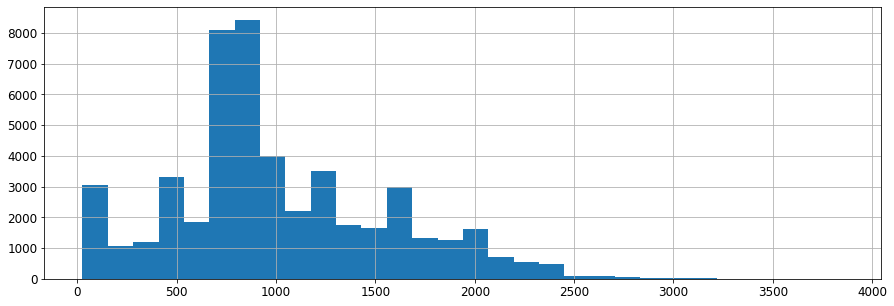

In [39]:
# Distribution of the number of days since last review
listings.time_since_last_review.hist(figsize=(15,5), bins=30);

In [40]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(listings.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [41]:
# Dropping last_review - first_review will be kept for EDA and dropped later
listings.drop('last_review', axis=1, inplace=True)

### **Review ratings columns**

- review_scores_rating - guests can score properties overall from 1 to 5 stars
- review_scores_accuracy - guests can score the accuracy of a property's description from 1 to 5 stars
- review_scores_cleanliness - guests can score a property's cleanliness from 1 to 5 stars
- review_scores_checkin - guests can score their check-in from 1 to 5 stars
- review_scores_communication - guests can score a host's communication from 1 to 5 stars
- review_scores_location - guests can score a property's location from 1 to 5 stars
- review_scores_value - guests can score a booking's value for money from 1 to 5 stars
- reviews_per_month - calculated field of the average number of reviews left by guest each month

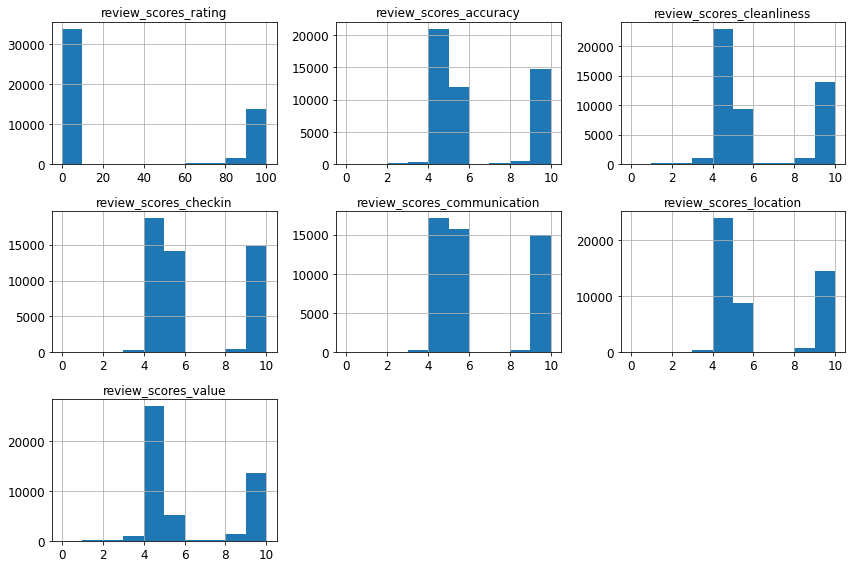

In [42]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(listings.columns[listings.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    listings[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

As above, listings without reviews will be kept and replaced with 'unknown'.

Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together 

In [43]:
variables_to_plot.pop(0)

'review_scores_rating'

In [44]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [45]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

# EDA

#### *Question: how long have hosts been listing properties on Airbnb in Amsterdam?*

In [46]:
print(f"The first joined on {min(listings.host_since).strftime('%d %B %Y')}, \
 and the most recent joined on {max(listings.host_since).strftime('%d %B %Y')}.")

The first joined on 24 September 2008,  and the most recent joined on 04 December 2021.


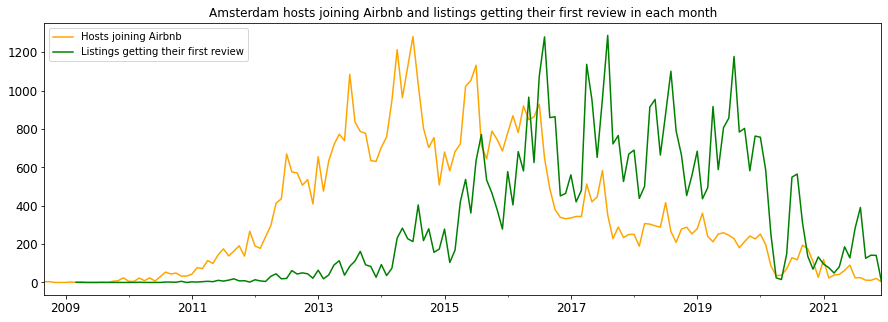

In [47]:
plt.figure(figsize=(15,5))
listings.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
listings.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='green')
plt.title('Amsterdam hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2008-09-01', '2021-12-31') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [48]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')

In [49]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(listings.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(listings.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

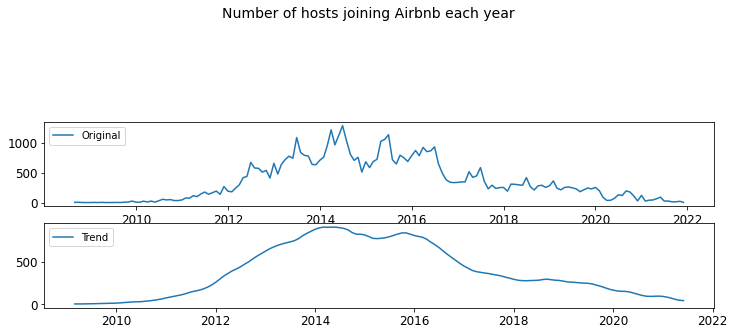

In [50]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each year')

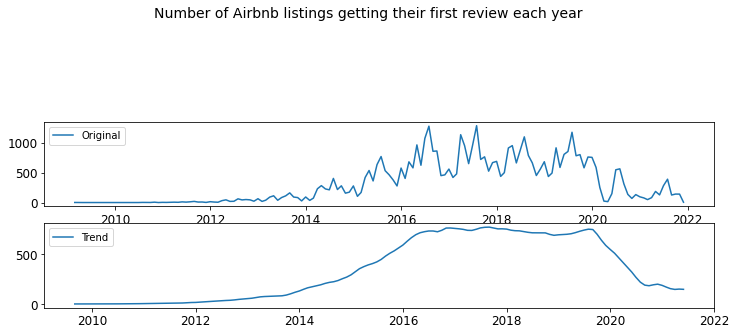

In [51]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each year')

### *Question: how have nightly prices changed over time?*

In [52]:
print("Mean nightly price of listings in each year on Airbnb in Amsterdam:")
print(round(listings.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in Amsterdam:
first_review
2009-01-01     59.00
2010-01-01    123.67
2011-01-01    123.62
2012-01-01    187.70
2013-01-01    171.63
2014-01-01    150.89
2015-01-01    153.28
2016-01-01    143.80
2017-01-01    152.34
2018-01-01    155.35
2019-01-01    161.23
2020-01-01    147.81
2021-01-01    155.03
Name: price, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


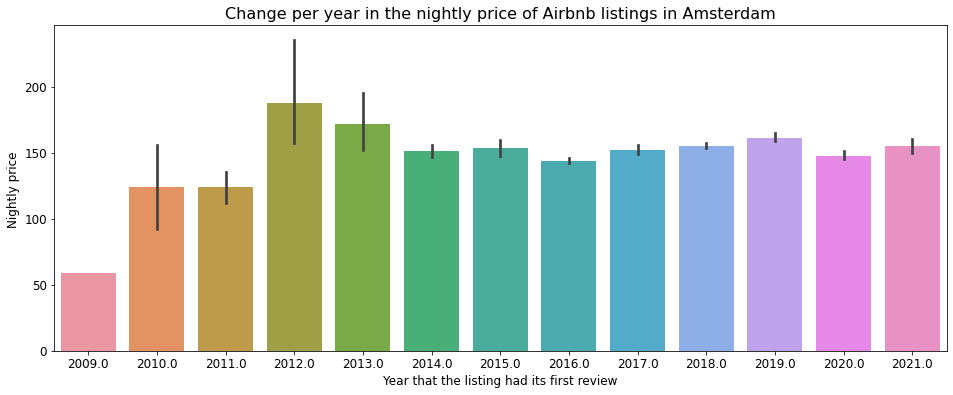

In [53]:
plt.figure(figsize=(16,6))
sns.barplot(listings.first_review.dt.year, listings.price)
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price ', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in Amsterdam', fontsize=16)
plt.show()

In [54]:
print(f"Nightly advertised prices range from ${min(listings.price)} to ${max(listings.price)}.")

Nightly advertised prices range from $0.0 to $8000.0.


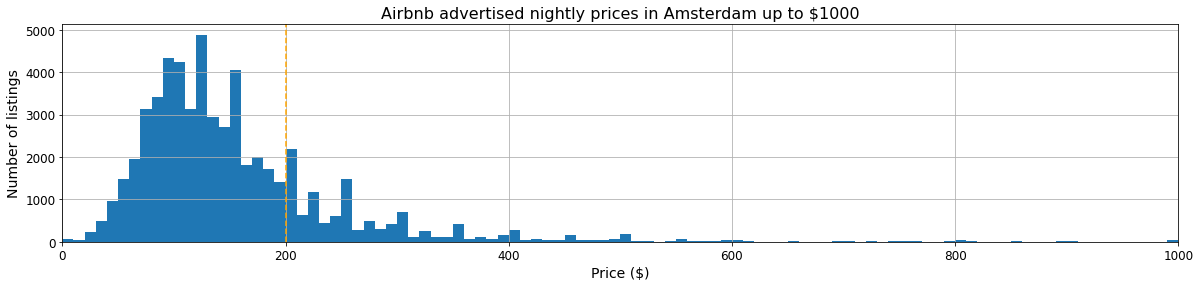

In [55]:
# Distribution of prices from $0 to $1000
plt.figure(figsize=(20,4))
listings.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in Amsterdam up to $1000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

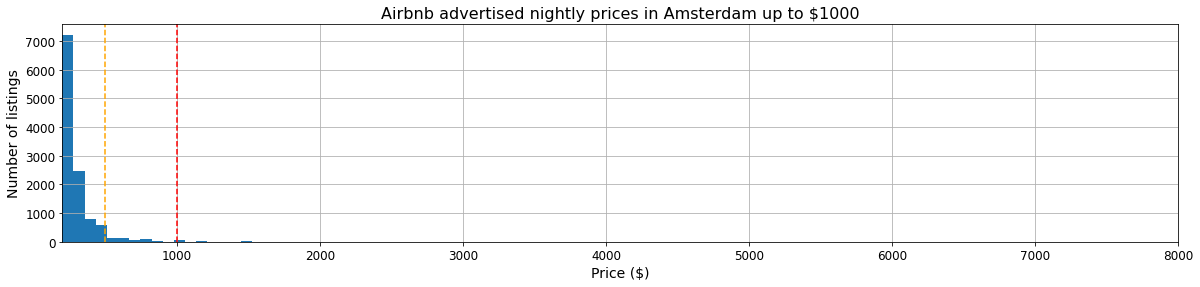

In [56]:
# Distribution of prices from $200 upwards
plt.figure(figsize=(20,4))
listings.price.hist(bins=100, range=(200, max(listings.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in Amsterdam up to $1000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [57]:
# Replacing values under $10 with $10
listings.loc[listings.price <= 10, 'price'] = 10

# Replacing values over $1000 with $1000
listings.loc[listings.price >= 1000, 'price'] = 1000

Dropping host_since and first_review

In [58]:
# Dropping host_since and first_review as they are no longer needed
listings.drop(['host_since', 'first_review'], axis=1, inplace=True)

## *Question: which areas have the most Airbnb properties, and which are the most expensive?* 

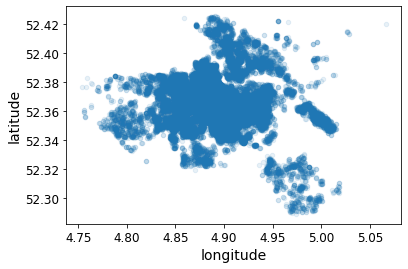

In [59]:
listings.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

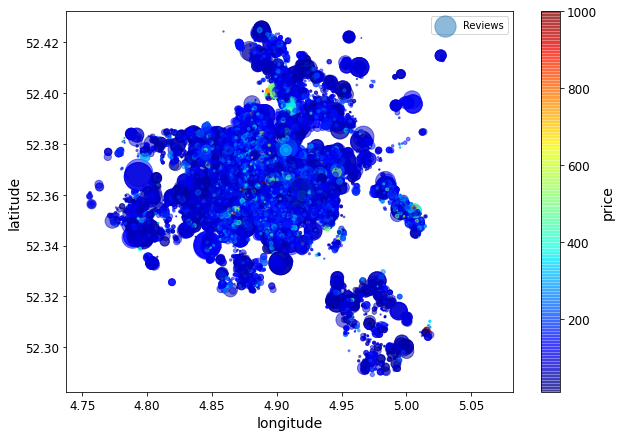

In [60]:
listings.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5,
    s=listings["number_of_reviews"], label="Reviews", figsize=(10,7),
    c="price", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

## *Question: what are the most common property and room types?*

In [61]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    listings[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

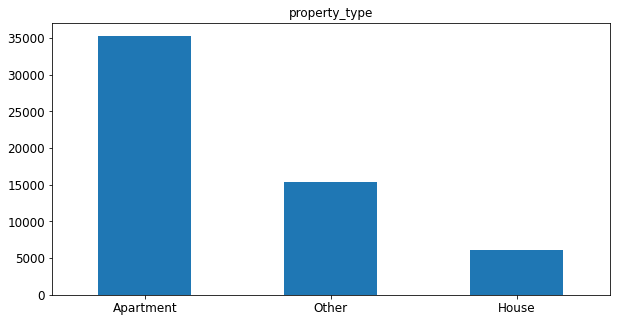

Apartment    0.622029
Other        0.271373
House        0.106599
Name: property_type, dtype: float64


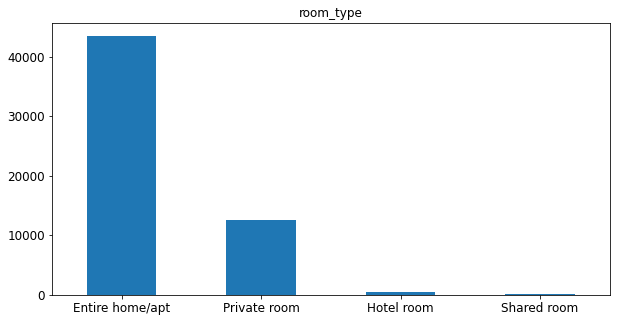

Entire home/apt    0.767052
Private room       0.222402
Hotel room         0.007724
Shared room        0.002821
Name: room_type, dtype: float64


In [62]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(10,5))
    print(listings[col].value_counts(normalize=True))

## *Question: what is the distribution of reviews like?*

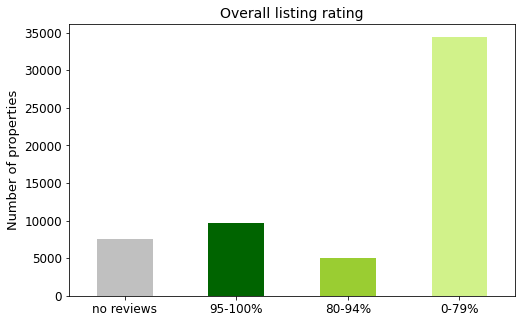

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title('Overall listing rating', fontsize=14)
listings['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', color=['silver', 'darkgreen', 'yellowgreen', '#d1f28a' ], ax=ax)
ax.set_xticklabels(labels=['no reviews', '95-100%', '80-94%', '0-79%'], rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Number of properties', fontsize=13)
plt.show()

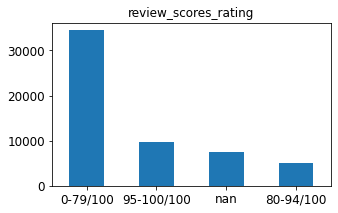

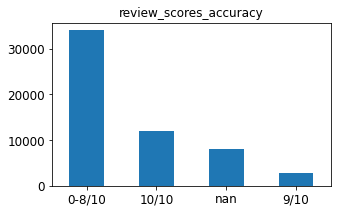

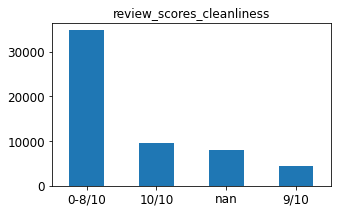

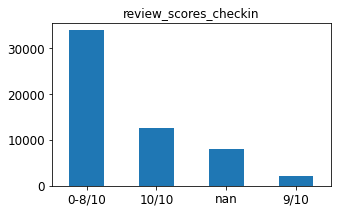

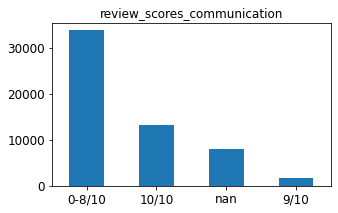

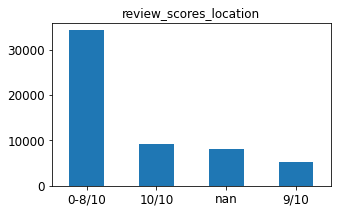

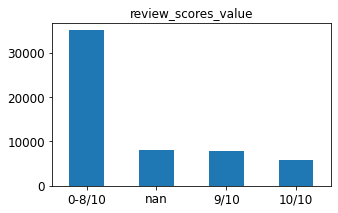

In [64]:
for col in list(listings.columns[listings.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

In [66]:
from pathlib import Path 
filepath = Path('/content/drive/MyDrive/airbnb/listings_processed.csv') 
listings.to_csv(filepath ,index=False)